In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""
#os.environ["CUDA_VISIBLE_DEVICES"]=""
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from i3cols_dataloader import load_events
from likelihood import LLH

%load_ext line_profiler

In [2]:
import tensorflow as tf

In [3]:
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

In [4]:
plt.rcParams['figure.figsize'] = [12., 8.]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

In [5]:
events, labels = load_events(dir='/home/iwsatlas1/peller/work/oscNext/level7_v01.04/140000_i3cols_test')

In [22]:
my_llh = LLH(hitnet_file='models/HitNet_08_May_2020-16h02/epoch_3450_model.hdf5',
          chargenet_file='models/ChargeNet_08_May_2020-15h59/epoch_600_model.hdf5',
         )

# timings

In [11]:
N_test = np.logspace(0, 5, 10)
event = events[333]

timings = []
stddevs = []

for n in N_test:
    params = np.repeat(event['params'][np.newaxis, :], n, axis=0)
    params += np.random.randn(*params.shape)
    t = %timeit -o llh = my_llh(event, params)
    timings.append(t)

57.1 ms ± 265 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
59.4 ms ± 2.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
61.8 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
60 ms ± 776 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
68 ms ± 584 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
116 ms ± 700 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
243 ms ± 4.12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
578 ms ± 17.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.64 s ± 31.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.5 s ± 198 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


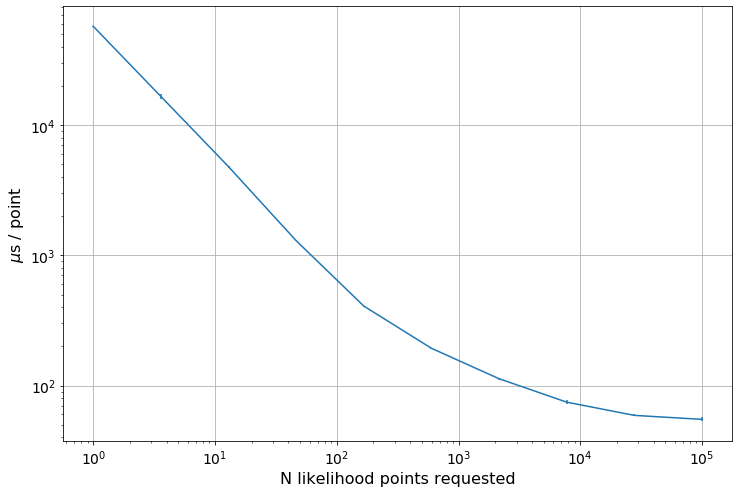

In [12]:
mean = np.array([t.average for t in timings])/N_test * 1e6
std = np.array([t.stdev for t in timings])/N_test * 1e6

plt.errorbar(N_test, mean, yerr=std)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel('N likelihood points requested')
plt.gca().set_ylabel(r'$\mu$s / point')
plt.grid()
plt.savefig('timings_cpu_single.png')

In [272]:
len(event['hits'])

21

In [23]:
%lprun -f my_llh.__call__ my_llh(event, np.repeat(event['params'][np.newaxis, :], 10000, axis=0))

Timer unit: 1e-06 s

Total time: 0.927922 s
File: /home/iwsatlas1/peller/freeDOM/freeDOM/likelihood.py
Function: __call__ at line 27

Line #      Hits         Time  Per Hit   % Time  Line Contents
    27                                               def __call__(self, event, params):
    28                                                   """Evaluate LLH for a given event + params
    29                                           
    30                                                   event : dict containing:
    31                                                       'total_charge' : float
    32                                                       'hits' : array shape (n_hits, 5)
    33                                                           each row is (x, y, z) DOM poitions, time, charge
    34                                                   params : ndarray
    35                                                       shape (n_likelihood_points, len(labels)) 
    36        